In [3]:
# Este notebook contien los procedimeintos para crear el parquet asociado a la ejecucion de la funcion de 
# RECOMENDACION DE JUEGOS
import pandas as pd
import json

In [3]:
def leo_lineaxlinea(arch_txt):
    # Listas para almacenar los diccionarios y los números de línea con errores
    data_list = []
    lineas_con_errores = []

    # Contadores para el total de líneas y registros leídos correctamente
    total_lineas = 0
    registros_correctos = 0

    # Abrir el archivo y leerlo línea por línea
    with open(arch_txt, 'r', encoding='utf-8') as archivo:
        for num_linea, linea in enumerate(archivo, start=1):
            total_lineas += 1
            try:
            # Intentar cargar la línea como JSON
                data = json.loads(linea)
                data_list.append(data)
                registros_correctos += 1
            except json.JSONDecodeError:
                try:
                    # Si falla como JSON, intentar cargarlo como diccionario
                    data = eval(linea)  # Usa eval para interpretar la línea como un diccionario
                    if isinstance(data, dict):
                        data_list.append(data)
                        registros_correctos += 1
                    else:
                         lineas_con_errores.append(num_linea)
                except Exception as e:
                    lineas_con_errores.append(num_linea)
    # Imprimir los resultados
    print(f'Total de líneas o registros: {total_lineas}')
    print(f'Registros leídos correctamente: {registros_correctos}')
    print(f'Registros mal leídos en líneas: {lineas_con_errores}')
    
    return data_list

    

In [4]:
# Crear un DataFrame a partir de games, es mi forma mas eficiente para leer el gz

lista=leo_lineaxlinea("..\steam_games.txt")
df_games = pd.DataFrame(lista)


Total de líneas o registros: 120445
Registros leídos correctamente: 120445
Registros mal leídos en líneas: []


In [5]:
#borro los que sean todos nulos xq habian muchos
df_games.dropna(how="all",inplace=True)

In [6]:
#ordeno el df por clave id para ver si hay duplicados
df_games = df_games.sort_values(by='id')

In [7]:

df_games.reset_index(inplace=True)

In [10]:

# Eliminar las filas duplicadas por "app_name" y aquellas en las que al menos una columna es None
# para posterior control copio en otro dataframe
df_games2 = df_games.dropna(subset=["app_name"]).drop_duplicates(subset="app_name", keep="first")

# Supongamos que tienes un DataFrame df_games y deseas encontrar las filas con valores iguales en la columna "app_name"
filas_duplicadas = df_games2[df_games2.duplicated(subset="app_name", keep=False)]

# Mostrar las filas duplicadas
filas_duplicadas
df_games=df_games2

In [ ]:
df_games['tags']

0        [Action, FPS, Multiplayer, Shooter, Classic, T...
1                           [Indie, Fighting, Multiplayer]
2                         [Animation & Modeling, Software]
3        [Zombies, World War II, FPS, Action, Multiplay...
4                                   [Animation & Modeling]
                               ...                        
32128    [Indie, Platformer, Casual, Puzzle, Physics, A...
32129              [Casual, Puzzle, Relaxing, Exploration]
32130    [Free to Play, Massively Multiplayer, Adventur...
32131    [Free to Play, Massively Multiplayer, Puzzle, ...
32132                                  [Action, Adventure]
Name: tags, Length: 32094, dtype: object

In [11]:
df_games=df_games.dropna()

In [12]:
import pandas as pd

# Supongamos que df_games es tu DataFrame con una columna 'tags' que contiene listas de etiquetas
# Vamos a crear una lista de DataFrames que representan las etiquetas desanidadas
df_tags_list = df_games['tags'].apply(lambda x: pd.Series(x))


<Axes: >

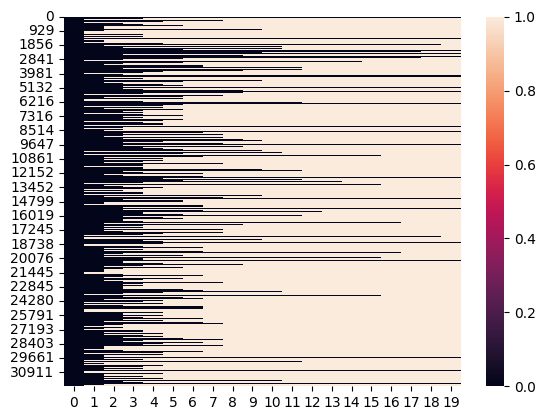

In [13]:
import seaborn as sns
sns.heatmap(df_tags_list.isnull())

In [19]:

# mas alla de la columna 2 hay muchos nulos
df_tags_list=df_tags_list[[0,1,2]]
# Renombrar las columnas con nombres significativos (puedes personalizar estos nombres)
df_tags_list.columns = ['tag_1', 'tag_2', 'tag_3']

# Concatenar los DataFrames de etiquetas desanidadas al DataFrame original
df_games = pd.concat([df_games, df_tags_list], axis=1)

# Eliminar la columna original 'tags' si ya no la necesitas
#df_games = df_games.drop('tags', axis=1)


In [15]:
len(df_games)
len(df_tags_list)

22505

In [16]:
df_games=df_games.drop(['index', 'publisher', 'genres', 'title', 'url',
       'release_date', 'tags', 'reviews_url', 'specs', 'price', 'early_access',
        'developer'],axis=1)

In [ ]:
null_count = df_games['tag_3'].isna().sum()
null_count

6146

In [4]:
df_games=pd.read_parquet("Game_recom.parquet")
# Eliminar las filas con índices impares
df_games = df_games[df_games.index % 2 == 0]


In [15]:
df_games = df_games[df_games.index % 2 == 0]
len(df_games)

1024

In [16]:
df_games=df_games.reset_index(drop=True)

In [21]:
#borro todos los nulos
df_games = df_games.dropna(subset=['tag_1'])
df_games = df_games.dropna(subset=['tag_2'])
df_games = df_games.dropna(subset=['tag_3'])

In [18]:
df_games.to_parquet("Game_recom.parquet")


In [22]:

from sklearn.metrics.pairwise import cosine_similarity



In [6]:
df_games=df_games.reset_index(drop=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combina las cuatro columnas en una columna de texto
df_games['combined_text'] = df_games['tag_1'] + ' ' + df_games['tag_2'] + ' ' + df_games['tag_3'] 

# Crea una instancia del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Aplica el vectorizador a la columna de texto combinada
tfidf_matrix = tfidf_vectorizer.fit_transform(df_games['combined_text'])

# Calcula la similitud del coseno en función de las características TF-IDF
similarity_matrix = cosine_similarity(tfidf_matrix)


In [97]:
similarity_matrix.shape

(8191, 8191)

In [8]:
df_games

,app_name,id,tag_1,tag_2,tag_3,combined_text
0,Rag Doll Kung Fu,1002,Indie,Fighting,Multiplayer,Indie Fighting Multiplayer
1,King's Quest™ Collection,10100,Adventure,Point & Click,Classic,Adventure Point & Click Classic
2,3D Ultra™ Minigolf Adventures,10140,Sports,Mini Golf,Golf,Sports Mini Golf Golf
3,Postal III,10220,Action,Dark Humor,Gore,Action Dark Humor Gore
4,Kingdoms of Amalur: Reckoning™,102500,RPG,Fantasy,Open World,RPG Fantasy Open World
...,...,...,...,...,...,...
4091,Naval Warfare,98500,Action,Indie,Steampunk,Action Indie Steampunk
4092,Dungeons of Dredmor,98800,Rogue-like,Turn-Based,RPG,Rogue-like Turn-Based RPG
4093,Test Drive Unlimited 2,9930,Racing,Open World,Driving,Racing Open World Driving
4094,Garshasp: Temple of the Dragon,99410,Action,Indie,Hack and Slash,Action Indie Hack and Slash


In [98]:
def get_recommendations(game_name, similarity_matrix, df):
    # Encuentra el índice del juego en el DataFrame
    
    game_index = df[df['id'] == game_name]
   
    game_index = df[df['id'] == game_name].index[0]
    # Obtén las puntuaciones de similitud para ese juego
    similar_scores = list(enumerate(similarity_matrix[game_index]))
    
    # Ordena las puntuaciones en orden descendente
    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)
    # Recupera los índices de los juegos similares
    similar_game_indices = [i[0] for i in similar_scores]
    # Devuelve los nombres de los juegos recomendados
   
    return df['app_name'].iloc[similar_game_indices[1:6]]


In [109]:
get_recommendations("9980",similarity_matrix,df_games)

8189                     The UnderGarden
2345                       Quell Reflect
3211    Mondrian - Abstraction in Beauty
4250                Catch a Falling Star
2599                              Lumini
Name: app_name, dtype: object

In [100]:

# Convierte la matriz similarity_matrix en un DataFrame
similarity_df = pd.DataFrame(similarity_matrix)

# Especifica el nombre del archivo Parquet en el que deseas guardar la matriz
parquet_filename = 'matrix.csv'

# Guarda el DataFrame en formato Parquet
similarity_df.to_csv(parquet_filename , index=False)


In [82]:
import pandas as pd

# Convierte la matriz similarity_matrix en un DataFrame
similarity_df = pd.DataFrame(similarity_matrix)

# Especifica el nombre del archivo CSV en el que deseas guardar la matriz
csv_filename = 'similarity_matrix.csv'

# Guarda el DataFrame en formato CSV
similarity_df.to_csv(csv_filename, index=False)
